# Step 1
1. Loading the target dataset, spliting train data, validation data and test data
2. Implement a Pytorch dataloader for the target dataset; Loading the target dataset

In [0]:
import torch
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np

#define transforms
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (1.0,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=trans)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=trans)
print(mnist_testset)

valid_size=1/6
num_train = len(mnist_trainset)
#indices = list(range(num_train))
split = int(1/6*num_train)

#train_idx, valid_idx = indices[split:],indices[:split]

train_set = torch.utils.data.Subset(mnist_trainset,range(split))
valid_set = torch.utils.data.Subset(mnist_trainset,range(split,num_train))
test_set = mnist_testset
print(type(mnist_trainset)) 
print(test_set.targets)

Dataset MNIST
    Number of datapoints: 10000
    Root location: ./data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(1.0,))
           )
<class 'torchvision.datasets.mnist.MNIST'>
tensor([7, 2, 1,  ..., 4, 5, 6])


In [0]:
batch_size = 100

train_loader = torch.utils.data.DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True)
valid_loader = torch.utils.data.DataLoader(
    dataset=valid_set,
    batch_size=batch_size,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=True)

print ('==>>> total trainning batch number: {}'.format(len(train_loader)))
print ('==>>> total validing batch number: {}'.format(len(valid_loader)))
print ('==>>> total testing batch number: {}'.format(len(test_loader)))


==>>> total trainning batch number: 100
==>>> total validing batch number: 500
==>>> total testing batch number: 100


# Step 2
1. Implementing a baseline model: Implement a simple 2-layer (1-hidden layer) MLP.
2. Training & drawing the loss.
We can see in the diagram, the loss & validation is crossed in an epoch where we should do the early stopping.


In [0]:
import torch.nn as nn
import torch.nn.functional as F

class MLPNet(nn.Module):
  def __init__(self):
    super(MLPNet,self).__init__()
    self.fc1 = nn.Linear(28*28,500)
  def forward(self,x):
    x = x.view(-1,28*28)
    x = F.relu(self.fc1(x))
    return x

model = MLPNet()

In [0]:
from keras.callbacks import EarlyStopping
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay= 1e-6, momentum=0.9)

criterion = nn.CrossEntropyLoss()

train_losses, valid_losses = [], []
train_mean_loss, valid_mean_loss = [], []
for epoch in range(20):
    # training
    model.train()
    for batch_idx, (x, target) in enumerate(train_loader,1):
        optimizer.zero_grad()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # valuation
    model.eval()
    for data,target in valid_loader:
      out = model(data)
      loss = criterion(out,target)
      valid_losses.append(loss.item())

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    train_mean_loss.append(train_loss)
    valid_mean_loss.append(valid_loss)

    print_msg = (f'epoch: {epoch} ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
      
    print(print_msg)

epoch: 0 train_loss: 0.82603 valid_loss: 0.43019


KeyboardInterrupt: ignored

In [0]:
plt.plot(train_mean_loss)
plt.plot(valid_mean_loss)

plt.show()

In [0]:

# initialize lists to monitor test loss and accuracy
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

# Step 3
1. Add layer: Implementing a baseline model: Implement a simple 3-layer (2-hidden layers) MLP.
2. Training & drawing the loss.
We can see in the diagram, the loss & validation is crossed in an epoch where we should do the early stopping.

In [0]:
import torch.nn as nn
import torch.nn.functional as F

class MLPNet(nn.Module):
  def __init__(self):
    super(MLPNet,self).__init__()
    self.fc1 = nn.Linear(28*28,500)
    self.fc2 = nn.Linear(500,256)
    self.fc3 = nn.Linear(256, 10)
  def forward(self,x):
    x = x.view(-1,28*28)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

model = MLPNet()

In [0]:
import torch.optim as optim
from torch.autograd import Variable
import matplotlib.pyplot as plt

optimizer = optim.SGD(model.parameters(), lr=0.05, weight_decay= 1e-6, momentum=0.9)

criterion = nn.CrossEntropyLoss()

train_losses, valid_losses = [], []
train_mean_loss, valid_mean_loss = [], []

for epoch in range(10):
    # training
    model.train()
    for batch_idx, (x, target) in enumerate(train_loader,1):
        optimizer.zero_grad()
        x, target = Variable(x), Variable(target)
        out = model(x)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    # valuation
    model.eval()
    for data,target in valid_loader:
      out = model(data)
      loss = criterion(out,target)
      valid_losses.append(loss.item())

    train_loss = np.average(train_losses)
    valid_loss = np.average(valid_losses)
    train_mean_loss.append(train_loss)
    valid_mean_loss.append(valid_loss)

      
    print_msg = (f'epoch: {epoch+1} ' +
                    f'train_loss: {train_loss:.5f} ' +
                    f'valid_loss: {valid_loss:.5f}')
      
    print(print_msg)


epoch: 1 train_loss: 0.00055 valid_loss: 0.19765
epoch: 2 train_loss: 0.00053 valid_loss: 0.19855
epoch: 3 train_loss: 0.00051 valid_loss: 0.19872
epoch: 4 train_loss: 0.00050 valid_loss: 0.19914
epoch: 5 train_loss: 0.00048 valid_loss: 0.19953
epoch: 6 train_loss: 0.00047 valid_loss: 0.20000
epoch: 7 train_loss: 0.00046 valid_loss: 0.20065
epoch: 8 train_loss: 0.00045 valid_loss: 0.20116
epoch: 9 train_loss: 0.00044 valid_loss: 0.20158
epoch: 10 train_loss: 0.00043 valid_loss: 0.20209


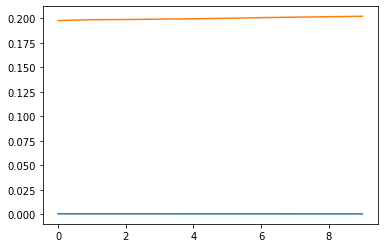

In [0]:
plt.plot(train_mean_loss)
plt.plot(valid_mean_loss)

plt.show()

In [0]:
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval() # prep model for evaluation

for data, target in test_loader:
    if len(target.data) != batch_size:
        break
    # forward pass: compute predicted outputs by passing inputs to the model
    output = model(data)
    # calculate the loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)
    # compare predictions to true label
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(10):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (
            str(i)))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.187583

Test Accuracy of     0: 97% (957/980)
Test Accuracy of     1: 98% (1121/1135)
Test Accuracy of     2: 96% (993/1032)
Test Accuracy of     3: 96% (971/1010)
Test Accuracy of     4: 96% (949/982)
Test Accuracy of     5: 93% (831/892)
Test Accuracy of     6: 96% (924/958)
Test Accuracy of     7: 95% (982/1028)
Test Accuracy of     8: 95% (926/974)
Test Accuracy of     9: 94% (949/1009)

Test Accuracy (Overall): 96% (9603/10000)


#Step 4
1. data augmentation

*   plot the images
*   data augmentation


2. second-round training algorithms
3. Implement ensemble methods using ve models: (a) bootstrap aggregating
(bagging) (chapter 7.11 on the book) and (2) model averaging with dierent
random initialization. For each of (a) and (b), report test accuracy of individual
models as well as that of the ensemble model.

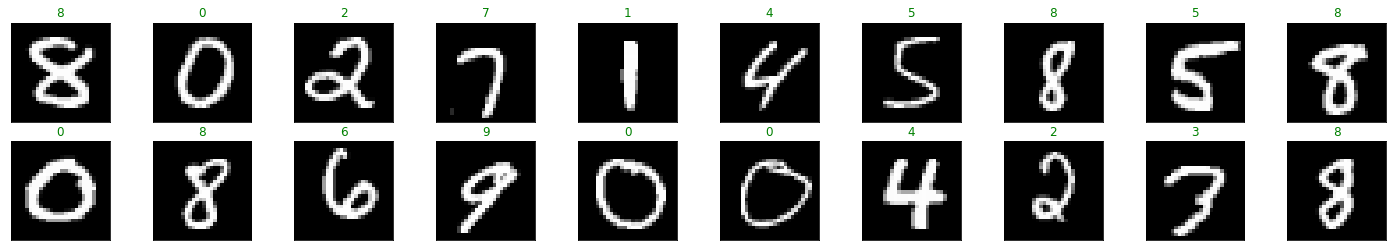

In [0]:
dataiter = iter(test_loader)
images, labels = dataiter.next()

images = images.numpy()
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
  ax.imshow(np.squeeze(images[idx]), cmap='gray')
  ax.set_title("{}".format(str(labels[idx].item())),
                 color=("green"))

TypeError: ignored

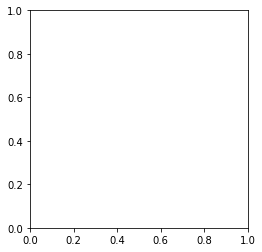

In [0]:
import matplotlib.pyplot as plt
for idx in np.arange(20):
  flipped_image = np.fliplr(np.squeeze(images[idx])
  plt.imshow(flipped_image)
  plt.show()